# Question 1: How can a Decision Tree be used to classify celestial objects (Stars, Galaxies, and Quasars)

## Introduction

### Overview

In this notebook I will explain how a decision tree can be used to classify different classes within a dataset. The dataset being used is the SDSS DR14 obtained from [Kaggle](https://www.kaggle.com/datasets/lucidlenn/sloan-digital-sky-survey/data.)

In this dataset, there are 18 columns that are used to describe the Stars, Galaxies, and Quasars observed by the SDSS telescope. However we don't necessarily need all 18 of these parameters.
- Columns: "objid", "run", "rerun", "camcol", "field", "specobjid", "plate", "mjd", and "fiberid", are all values related to the telescope so should not be relevent to classification
- Columns: "ra" and "dec" are positions of the celestial objects on the sky, and thus shouldn't be important when classifiying what class the objects fall into
- Columns: "u", "g", "r", "i", and "z" are all magnitudes related to the objects themselves, therefore they are important to classification
- The "redshift" column is also very important for classification as it is related to how far away the object is. Objects with higher redshifts are more likely to be brighter objects like galaxies or quasars, so we can expect redshift to be very important. However, for reasons I explain at the end of the notebook, I chose to neglect redshift and focus on the photometric magnitudes.
- The "class" column contains which class the objects fall into, this will be used for the labels.

### What is a Decision Tree and How Does it Work?

Decision trees are flow charts that are often used for classification or regression tasks. It works by splitting data into subsets based on the answer to a question. For example in this dataset, the data may be split based on the question "is the brightness above a certain value?" This would then split the data into two subsets, one with brightnesses greater than the chosen value, and one with brightnesses less than the chosen value.

The tree starts with the whole dataset and keeps splitting it until it reaches a stopping point, normally maximum depth or a minimum number of samples. It would end up looking something like this:

            Is brightness > 50?
                /         \
              Yes         No
             /             \
        Is size > 10?   Is size < 10?
          /     \         /     \
       Galaxy  Star    QSO   Star

This method is useful for classification problems as it can be very quick to find an answer, depending on the dataset and the depth of the tree.

In order to start making a tree we need to choose features (input variables) that can be used to help the model predict which class each object should be in. Each column in the dataset is a potential feature, except for the "class" column which will be our label set (the set that contains the actual classes of each object that we can train and test the model against). However, as I said earlier not every column will be useful. I have chosen to use only the photometric magnitudes ("u", "g", "r", "i", and "z") as these should be the most important in predicting the classes.

### Pros and Cons of Decision Trees

Pros:
- Easy to understand and interpret:
    - Decision trees are intuitive and easy to visualise (they can be shown graphically)
    - The tree structure makes it straightforward to understand how decisions are made
- Requires little data preparation:
    - They do not normally require feature scaling (normalisation or standardisation)
    - They can handle missing values, so we don't need to fill gaps with estimated values
- Feature Importance:
    - Decision trees provide insights into feature importance, which is useful for datasets (like SDSS DR14) that contain lots of potential features
- Handles multi-class classification:
    - Decision trees can naturally handle multi-class classification problems without requiring modifications

Cons:
- Prone to Overfitting:
    - Decision trees can easily overfit the training data, especially if the tree is allowed to grow too deep
    - This can lead to poor generalisation for new unseen data
    - Regularisation techniques like pruning, setting a maximum depth, or minimum samples per leaf are necessary to mitigate overfitting
- Sensitive to noisy data:
    - Decision trees are sensitive to small variations in the data
    - Noisy data can lead to the creation of complex trees that do not generalise well
- Computationally Intensive:
    - While normally quite quick, training a decision tree for large datasets can be computationally intensive and time-consuming, especially if the tree grows very deep

## Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## Initialising the dataset

In order to use the data, it needs to be initialised. First we load the data from a csv file and store it as a pandas dataframe.

In [3]:
# change the path to where the csv file is stored
path = "/Users/Ryan/Documents/Ryan's Documents/Uni/Year 4/Comp/Coursework 2/SDSS.csv"
data = pd.read_csv(path)
data

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.237650e+18,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345,301,3,161,5.033450e+17,GALAXY,0.027583,447,51877,246
9996,1.237650e+18,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345,301,3,162,5.033400e+17,GALAXY,0.117772,447,51877,228
9997,1.237650e+18,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345,301,3,162,8.222620e+18,STAR,-0.000402,7303,57013,622
9998,1.237650e+18,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345,301,3,163,5.033400e+17,GALAXY,0.014019,447,51877,229


Once the data has been loaded, we select only the columns we are going to be using.

In [4]:
features = data[['u', 'g', 'r', 'i', 'z']]
labels = data['class']
features

,u,g,r,i,z
0,19.47406,17.04240,15.94699,15.50342,15.22531
1,18.66280,17.21449,16.67637,16.48922,16.39150
2,19.38298,18.19169,17.47428,17.08732,16.80125
3,17.76536,16.60272,16.16116,15.98233,15.90438
4,17.55025,16.26342,16.43869,16.55492,16.61326
...,...,...,...,...,...
9995,18.81777,17.47053,16.91508,16.68305,16.50570
9996,18.27255,17.43849,17.07692,16.71661,16.69897
9997,18.75818,17.77784,17.51872,17.43302,17.42048
9998,18.88287,17.91068,17.53152,17.36284,17.13988


## Training and Testing the model

The data needs to be split into two parts, training and testing. The training set will be used to train the model on how to classify the objects. The testing set is then used to determine how good the model is at classifying objects.

The scikit-learn function, train_test_split, is used to separate the data into a 80/20 (train/test) ratio. It takes the dataset that we want to train the model with, as well as the set of labels, as inputs.

80/20 is a common ratio choice as it ensures there is enough data to actually teach the model the underlying patterns and relationships present, while still having a relatively large testing set. This ratio can be changed by increasing or decreasing the test_size parameter.

Setting the random states ensures that each time the cell is run the random processes within the algorithm (such as splitting the data) will produce the same results. 42 is an arbitary choice but is a convention in data science, in practice any integer can be used. It is a reference to Douglas Adams' book "The Hitchhiker's Guide to the Galaxy".

The function will return four arrays:
- training_param: Contains the input features used to train the model
- testing param: Contains the input features used to evaluate how good the model is
- train_classification: Contains the "true labels" that the model will train with
- testing_classification: Contains the "true labels" that the model will be tested against

In [5]:
training_param, testing_param, train_classification, testing_classification = train_test_split(features, labels, test_size=0.2, random_state=42)

clf is the standard abbreviation for "classifier". It stores the model that we are working with.

The DecisionTreeClassifier class is from scikit-learn and creates the decision tree classifier. By default a depth for the tree is not set. This means the model will grow until all the leaves are pure, or all leaves contain less than the minimum number of samples required to split. I explain later on in the notebook reasons for and against setting a depth and what a good depth would be for this task. Again the random seed is set to 42.

Running "fit" on clf is what actually trains the model. It uses the training set as input features and the training classification set as the labels. This is where the data is split into subsets and the tree structure is built.

In [6]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(training_param, train_classification); # The semicolon suppresses the output as it is not useful

Now we run "predict" on the model. This is where the model is tested on new data (the testing set we stored earlier). This will generate a class label for each of the objects in the testing set and store them all to an array.

In [7]:
classification_predict = clf.predict(testing_param)
print(classification_predict)

['GALAXY' 'QSO' 'STAR' ... 'STAR' 'STAR' 'GALAXY']


Now we can determine how accurate the model is by comparing the predicted classification with the true classification.

classification_report is an scikit-learn function that generates a detailed report of the classification model's performance, broken down by class.
  - Precision: The proportion of true positive predictions out of all positive predictions made
  - Recall (Sensitivity): The proportion of true positive predictions out of all actual positives
  - F1-Score: The harmonic mean of precision and recall
  - Support: The number of actual occurences of each class in the testing set
  - Accuracy: The proportion of correctly classified labels out of the total number of labels
  - Macro avg: The average of the precision, recall, and F1-score for each class, calculated independently for each class and then averaged
  - Weighted avg: The average of the precision, recall, and F1-score for each class, weighted by the number of instances in each class.

In [8]:
# Print the classification report to 4 decimal places
print('Classification Report:\n\n', classification_report(testing_classification, classification_predict, digits=4))

Classification Report:

               precision    recall  f1-score   support

      GALAXY     0.9129    0.9157    0.9143       996
         QSO     0.8710    0.8526    0.8617       190
        STAR     0.8933    0.8943    0.8938       814

    accuracy                         0.9010      2000
   macro avg     0.8924    0.8875    0.8899      2000
weighted avg     0.9009    0.9010    0.9010      2000



## Plotting the model

Seeing a numerical score is useful but visualising what it means can be tricky. This is why plotting is so helpful to fully understand what is going on. Here I will demonstrate a couple of useful plots to understand what the model is doing and what parts of it are good.

### Distribution of Classes in the Test Set

Here is a bar graph that shows how many objects the model correctly determined and the total objects that were actually there. From this we can see that the model was pretty good across all three classes.

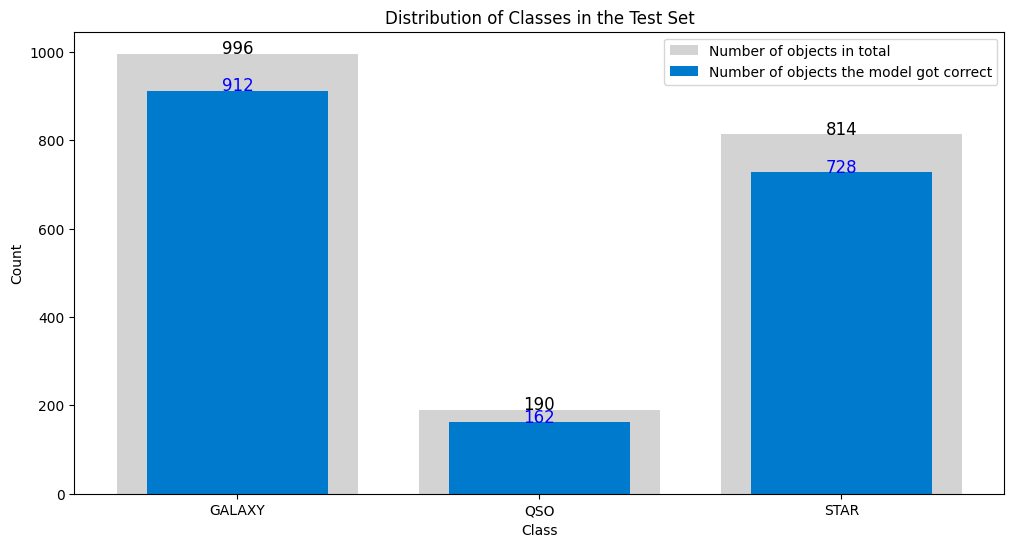

In [9]:
# Calculates the true number of objects in each class and sorts them by class
    # value_counts() returns the number of occurrences of each class in the testing_classification Series
    # sort_index() sorts the results by class
true_counts = testing_classification.value_counts().sort_index()

# Calculates the number of objects the model correctly identified for each class and sorts them by class
    # testing_classification == classification_predict returns a Series of True/False values, where True indicates the model was correct
    # value_counts() returns the number of occurrences of each class in the Series
    # sort_index() sorts the results by class
correct_counts = testing_classification[testing_classification == classification_predict].value_counts().sort_index()

# Combines true_counts and correct_counts into a single DataFrame for easier plotting
    # The 'Actual' column contains the true number of objects in each class
    # The 'Correctly Detected' column contains the number of objects the model correctly identified for each class
plot_data = pd.DataFrame({'Actual': true_counts, 'Correctly Detected': correct_counts})

# Sets the x positions for the bars, so that they are evenly spaced along the x axis
    # np.arange() returns an array of evenly spaced values
    # len(plot_data) returns the number of classes
x_positions = np.arange(len(plot_data))

# Set the figure size to be 12 inches by 6 inches (width by height), can be adjusted as needed
plt.figure(figsize=(12, 6))

# Plot the actual and correctly detected counts as bar graphs
    # plt.bar() plots a bar graph
    # x_positions sets the x position of the bars
    # plot_data['Actual'] and plot_data['Correctly Detected'] set the heights of the bars
    # width sets the width of the bars
    # color sets the color of the bars (grey for actual counts, blue for correctly detected counts)
    # label sets the label for the legend
plt.bar(x_positions, plot_data['Actual'], width=0.8, color='#d3d3d3', label='Number of objects in total')
plt.bar(x_positions, plot_data['Correctly Detected'], width=0.6, color='#007acc', label='Number of objects the model got correct')

# Add a title and labels
plt.title('Distribution of Classes in the Test Set')
plt.xlabel('Class')
plt.ylabel('Count')

# Sets x-axis tick labels to class names instead of numbers
plt.xticks(x_positions, plot_data.index)

# Add the maximum values at the top of the bars
for class_type in x_positions:
    # Get the actual and correctly detected values for the current class
    actual_value = plot_data['Actual'].iloc[class_type] # iloc is used to access the value at the specified index
    detected_value = plot_data['Correctly Detected'].iloc[class_type]
    
    # Add the actual and correctly detected values above the bars
        # plt.text() adds text to the plot
        # class_type sets the x position of the text
        # actual_value + 0.5 and detected_value + 0.5 set the y positions of the text
        # actual_value and detected_value set the text to be displayed
        # ha='center' centers the text horizontally
        # fontsize sets the size of the text
        # color sets the color of the text (black for actual counts, blue for correctly detected counts)
    plt.text(class_type, actual_value + 0.5, actual_value, ha='center', fontsize=12, color='black')
    plt.text(class_type, detected_value + 0.5, detected_value, ha='center', fontsize=12, color='blue')
    

# Add a legend and show the plot
plt.legend(loc='upper right')
plt.show()

### Visualising the Decision Tree

Using plot_tree from sklearn, the structure of the tree can be seen. This can take quite a long time (> 1 minute) for trees with lots of nodes.

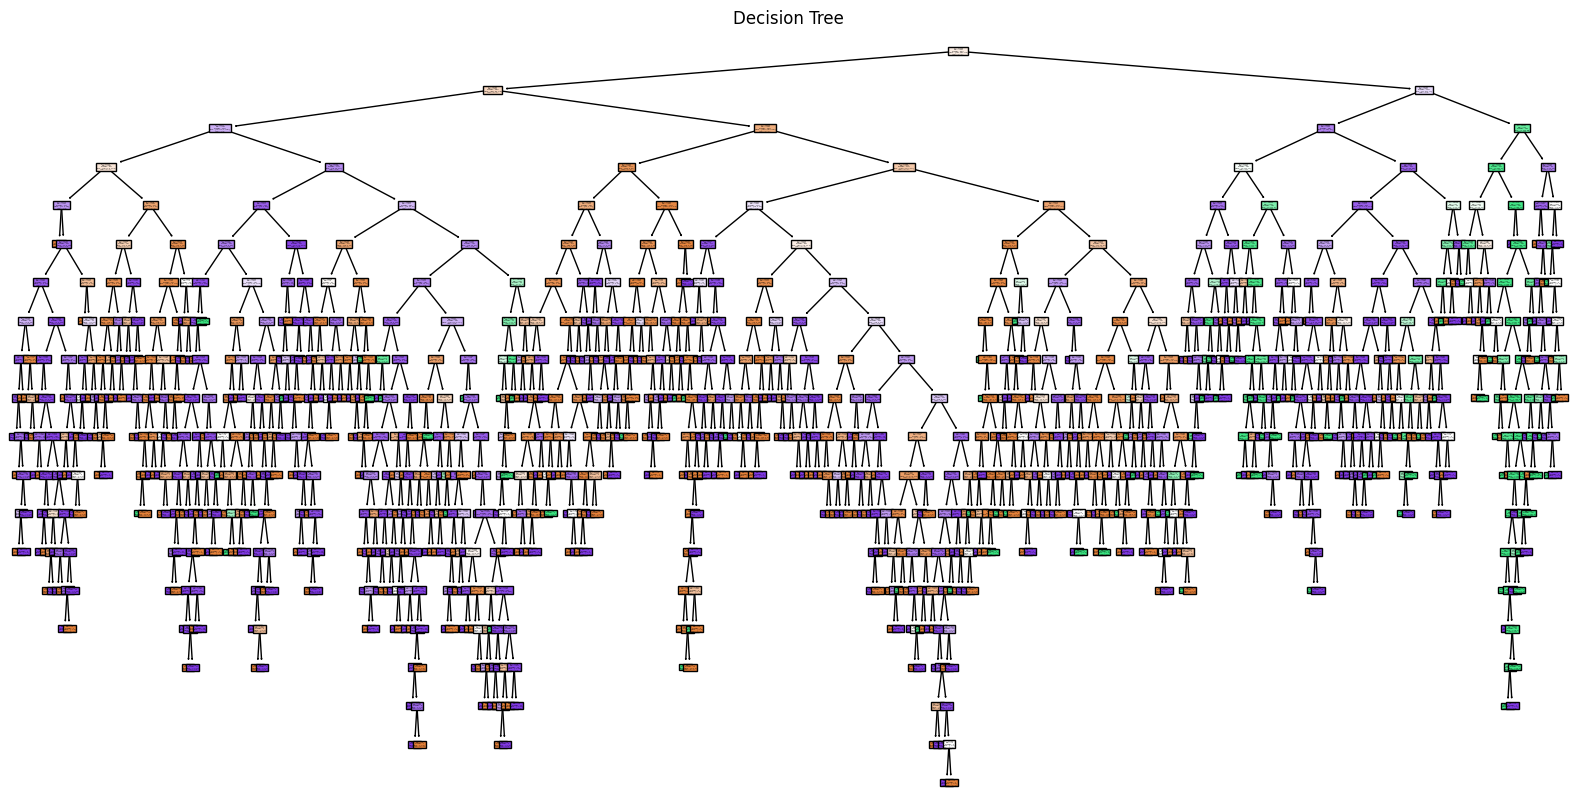

In [10]:
# Set the figure size to be 20 inches by 10 inches (width by height), can be adjusted as needed
plt.figure(figsize=(20, 10))

# Plot the decision tree
    # filled=True fills the boxes with colours
    # feature_names=features.columns sets the feature names to be the column names of the features DataFrame
    # class_names=clf.classes_ sets the class names to be the list of labels used in the classification
plot_tree(clf, filled=True, feature_names=features.columns, class_names=clf.classes_)
plt.title('Decision Tree')
plt.show()

Because we didn't specify a maximum depth when initilising the tree, it has kept growing until it is finished which makes it very large.

We can set a maximum depth by adding a parameter to the DecisionTreeClassifier class.

In [23]:
# Set the maximum depth for the decision tree
max_depth = 5  # You can change this value to any integer

# Initialize the DecisionTreeClassifier with the max_depth parameter
clf_test = DecisionTreeClassifier(random_state=42, max_depth=max_depth)

# Fit the model
clf_test.fit(training_param, train_classification);

Now that the maximum depth has been set to 5, the tree is much more easily readable.

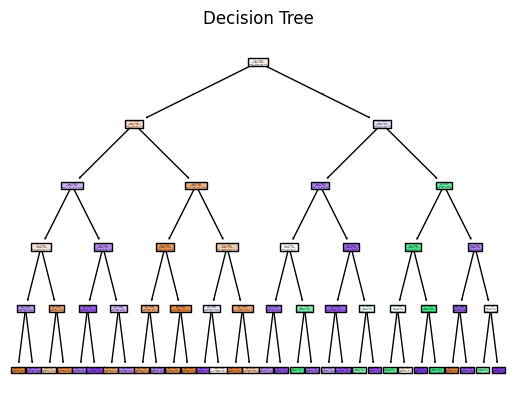

In [24]:
plot_tree(clf_test, filled=True, feature_names=features.columns, class_names=clf.classes_)
plt.title('Decision Tree')
plt.show()

The main reason to cut the tree down is to prevent overfitting. If the tree is allowed to grow untamed, then it can model the training data very closely, including capturing any noise that may be present. This could lead to the model performing worse on unseen data. The flipside to this is that if the maxmimum depth is set too low, the model can become underfit. This would mean the model doesn't have enough time during training to properly capture the underlying patterns in the data, and would decreaase its accuracy on unseen data.

### Feature Importance

The feature importance is a useful measure in determining the accuracy of the model. If a feature is more important it means that it will have a greater impact on the model's predictions. Knowing which features are more important is essential to gain insight into the underlying patterns in the data that the model has learned.

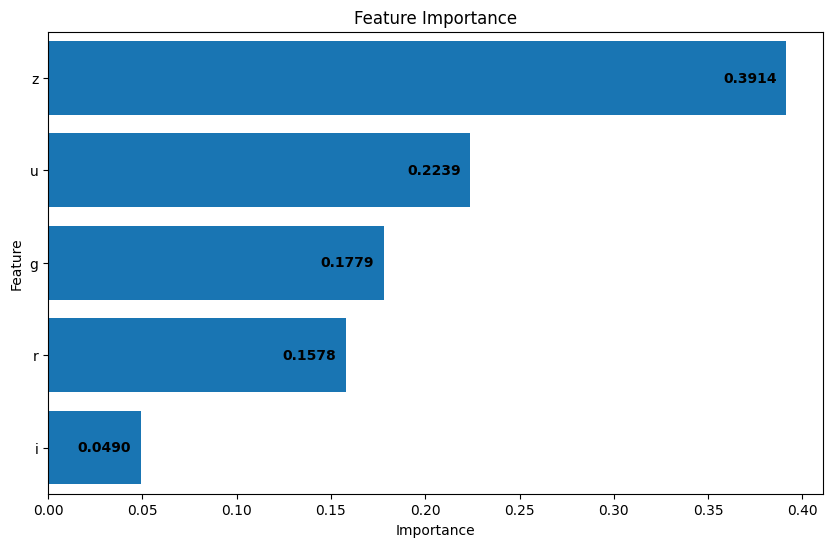

In [11]:
# Calculate feature importance
    # pd.Series() converts the feature importance values from a numpy array into a pandas Series
    # clf.feature_importances_ contains the feature importance values calculated by the DecisionTreeClassifier
    # index=features.columns argument uses the feature names from the features DataFrame as the index of the Series
    # .sort_values(ascending=False) sorts the Series in descending order
# This allows us to associate each importance score with the respective feature name and plot them in a bar chart
feature_importance = pd.Series(clf.feature_importances_, index=features.columns).sort_values(ascending=False)

# Set the figure size to be 10 inches by 6 inches (width by height), can be adjusted as needed
plt.figure(figsize=(10, 6))

# Plot feature importance
    # sns.barplot() creates a bar plot
    # x=feature_importance sets the x values to be the feature importance values
    # y=feature_importance.index sets the y values to be the feature names
    # color='#007acc' sets the colour of the bars to a shade of blue
sns.barplot(x=feature_importance, y=feature_importance.index, color='#007acc')

# Add maximum values to the tip of each bar
    # This loops over each of the features and displays the importance value at the end of the bar, to 4 decimal places
    # value-0.005 moves the text slightly to the left of the end of the bar
    # index is the y position of the bar
    # f'{value:.4f}' formats the value to 4 decimal places
    # va='center' and ha='right' set the vertical and horizontal alignment of the text
    # fontsize=10 sets the font size of the text to 10
    # color='black' sets the colour of the text to black
    # fontweight='bold' sets the font weight of the text to bold
for index, value in enumerate(feature_importance):
    plt.text(value-0.005, index, f'{value:.4f}', va='center', ha='right', fontsize=10, color='black', fontweight='bold')

# Add a title and labels, then show the plot
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Here we can see how each of the five filter bands are ordered in terms of importance, with 'z' being the most important and 'i' being the least.

If we had chosen to use all 18 columns, a feature importance plot would have shown which features were most influential. It would also have shown which features we could neglect from the model.

### Confusion Matrix

One of the most useful ways to visualise the model is with a confusion matrix. They provide a detailed breakdown of the performance of a classification model by comparing the "true labels" with the predicted labels.

Simply by looking at the grid we can see how accurate our model is at predicting each class. For high accuracy models, there should be a diagonal line of colour going from the top left down to the bottom right.

Sometimes it might be a good idea to normalise the confusion matrix. This allows us to visually compare the classes more easily, especially when they have different numbers of samples. The downside to normalising is we lose the exact number of counts for each box, so I have shown plots for both normalised and unnormalised to get the benefits of both.

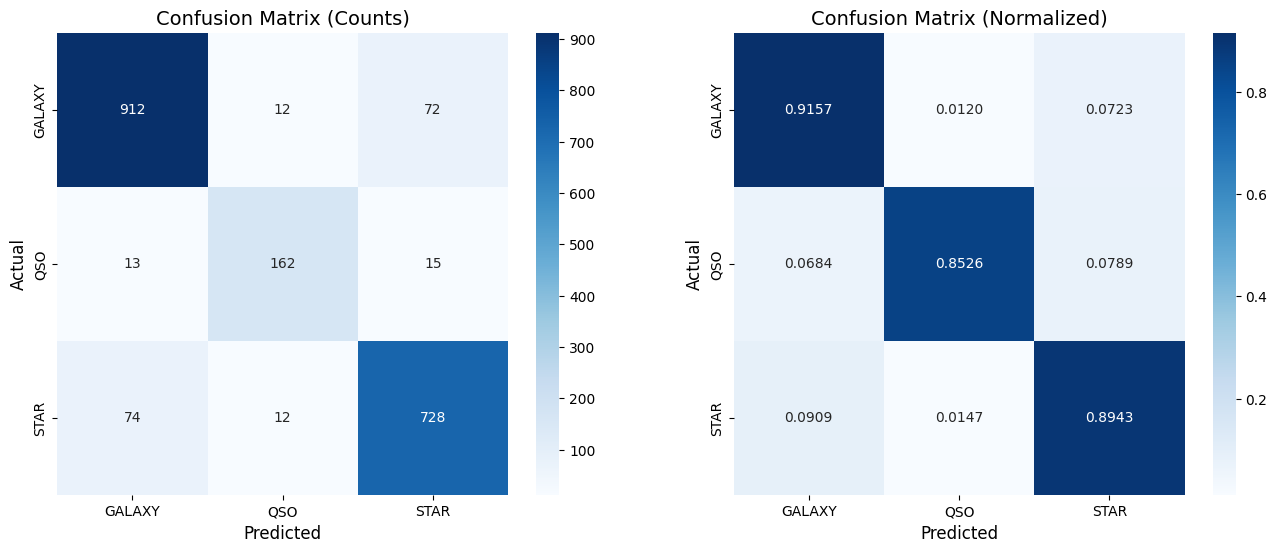

In [12]:
# conufusion_matrix is a function from sklearn that calculates the confusion matrix
cm = confusion_matrix(testing_classification, classification_predict)

# Normalize the confusion matrix
    # cm.sum(axis=1) calculates the sum of each row
    # [:, np.newaxis] adds a new axis to the array to allow for broadcasting
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure with two subplots, one for the unnormalized confusion matrix and one for the normalized confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the unnormalized confusion matrix as a heatmap
    # sns.heatmap() creates a heatmap
    # cm is the confusion matrix
    # annot=True displays the numbers in each cell
    # fmt='d' formats the numbers as integers
    # cmap='Blues' sets the colour scheme to blue
    # xticklabels=clf.classes_ sets the x-axis labels to the class names
    # yticklabels=clf.classes_ sets the y-axis labels to the class names
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_, ax=axes[0])

# Plot the normalized confusion matrix as a heatmap
    # sns.heatmap() creates a heatmap
    # cm_normalized is the normalized confusion matrix
    # annot=True displays the numbers in each cell
    # fmt='.2f' formats the numbers as floating point numbers with 4 decimal places
    # cmap='Blues' sets the colour scheme to blue
    # xticklabels=clf.classes_ sets the x-axis labels to the class names
    # yticklabels=clf.classes_ sets the y-axis labels to the class names
sns.heatmap(cm_normalized, annot=True, fmt='.4f', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_, ax=axes[1])

# Add labels and a title to each plot
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14)
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

# Show the plots
plt.show()

## Why do I Ignore Redshift?

The reason I chose to ignore redshift can be seen below where I plot the feature importance with all 17 feature columns.

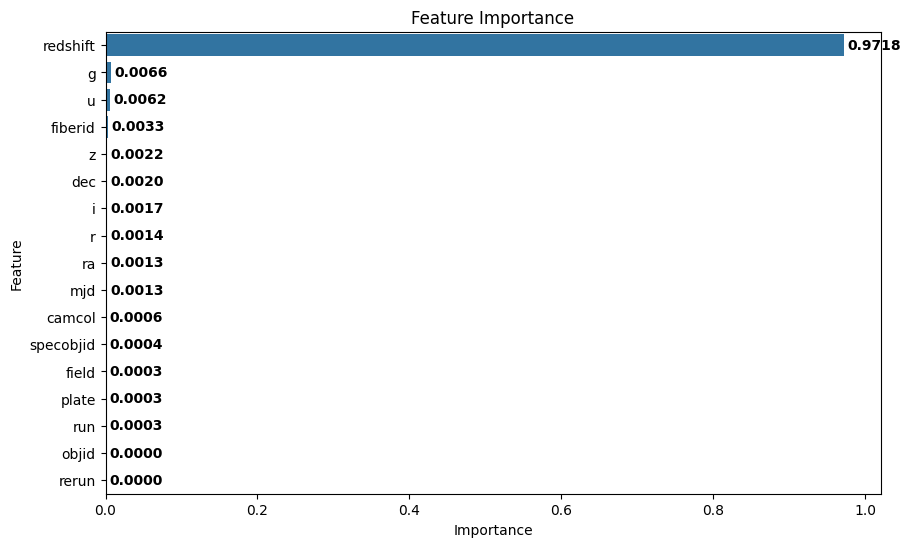

In [13]:
# Load the dataset
path = "/Users/Ryan/Documents/Ryan's Documents/Uni/Year 4/Comp/Coursework 2/SDSS.csv"
data = pd.read_csv(path)

# Separate the features and the target variable
test_features = data.drop(['class'], axis=1)
test_labels = data['class']

# Train the Decision Tree classifier
test = DecisionTreeClassifier(random_state=42)
test.fit(test_features, test_labels)

# Calculate feature importance
feature_importance_test = pd.Series(test.feature_importances_, index=test_features.columns)
feature_importance_test = feature_importance_test.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_test, y=feature_importance_test.index)
for index, value in enumerate(feature_importance_test):
    plt.text(value+0.075, index, f'{value:.4f}', va='center', ha='right', fontsize=10, color='black', fontweight='bold')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Because of how dominant redshift is it becomes the only feature that is needed in order to get a very high accuracy.

The most likely reason redshift is so important is that it is highly correlated with the classes. This can be seen below; where stars are all in low redshift (between -0.005 and +0.005); Galaxies are medium (between 0 and 1); and QSO are high (between 0 and 6).

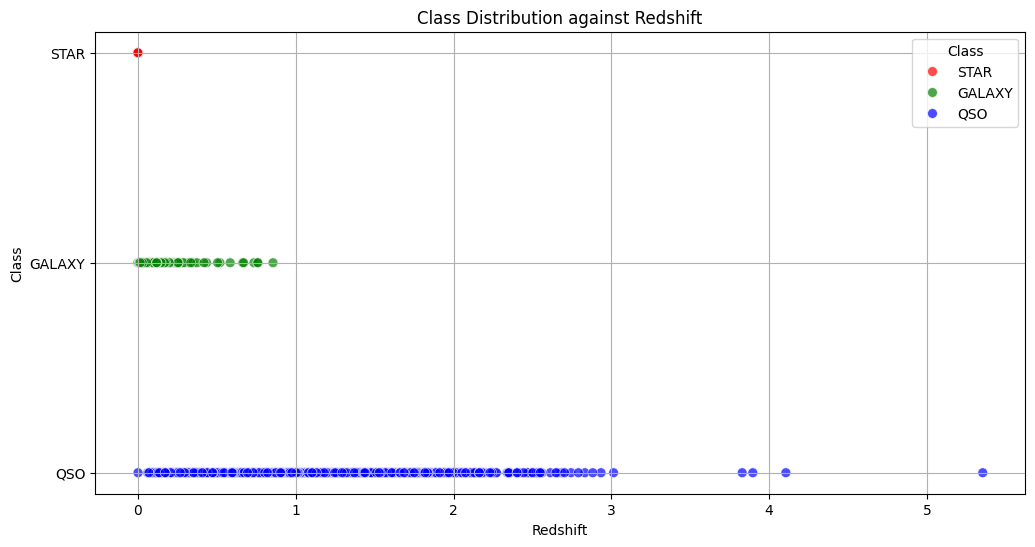

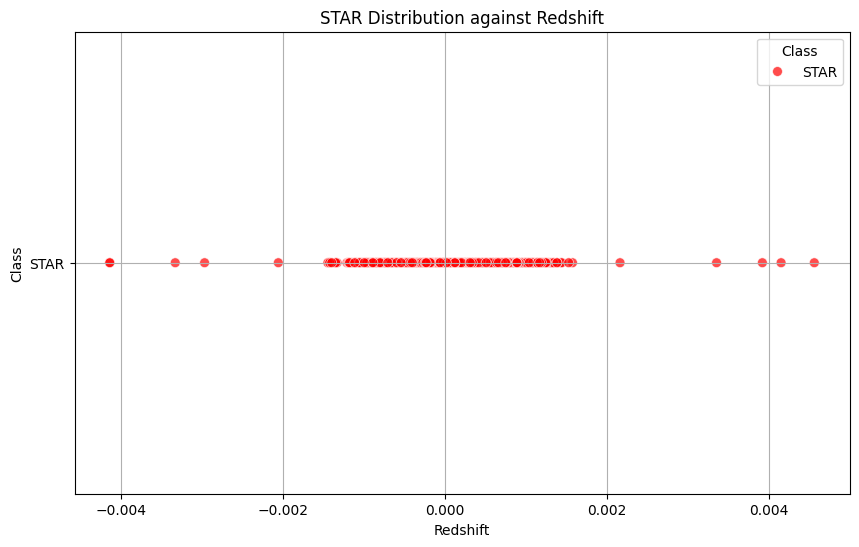

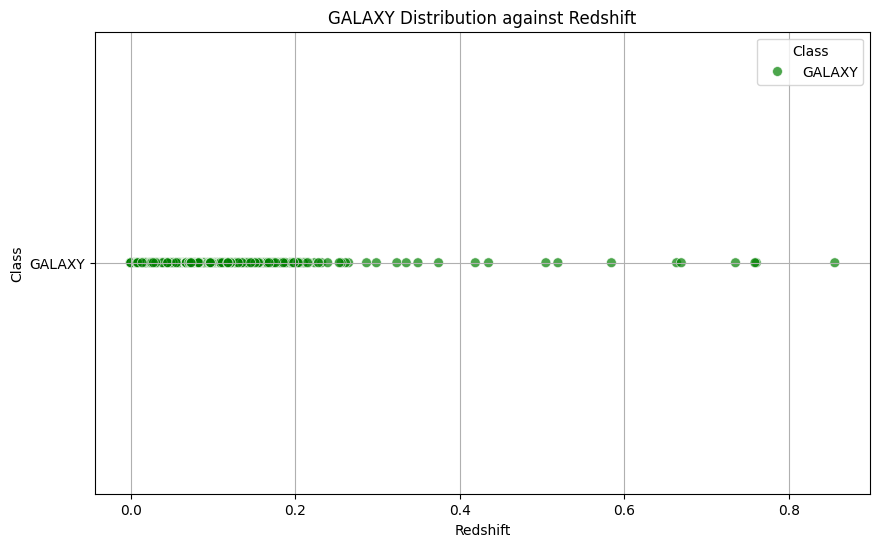

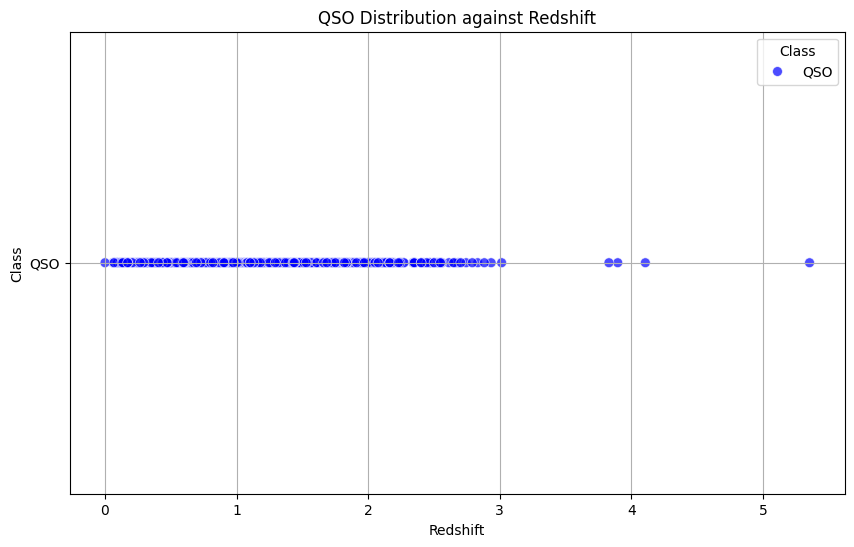

In [16]:
# Define a custom palette
custom_palette = {'STAR': 'red', 'GALAXY': 'green', 'QSO': 'blue'}

# Plot all classes against redshift
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='redshift', y='class', hue='class', palette=custom_palette, s=50, alpha=0.7)
plt.title('Class Distribution against Redshift')
plt.xlabel('Redshift')
plt.ylabel('Class')
plt.legend(title='Class')
plt.grid(True)
plt.show()

# Define the classes
classes = data['class'].unique()

# Create a plot for each class
for cls in classes:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data[data['class'] == cls], x='redshift', y='class', hue='class', palette=custom_palette, s=50, alpha=0.7)
    plt.title(f'{cls} Distribution against Redshift')
    plt.xlabel('Redshift')
    plt.ylabel('Class')
    plt.legend(title='Class')
    plt.grid(True)
    plt.show()